# Training a ResNet neural-network decoder

We will now train a ResNet50 model to decode a code of length 5 subject to independent bit- and phase-flip noise ('uncorrelated') near the threshold error rate.

In [1]:
SRC_PATH = '../Python' # path to src

import os
import sys
from hexagonal_lattice import HexagonalLattice

sys.path.append(os.path.abspath(SRC_PATH))
lattice = HexagonalLattice(5,5) # Code on a lattice of length 5

## Data generation
First, we will need to create the pattern data and the training data if they were not created before (this may take a few hours depending on your computer and the dataset size, see README files and other notebooks for more information). Pattern data can be obtained by:

In [2]:
import compute_pattern as cp
cp.compute_all_patterns(max_length=13)

Pattern data ready.


The model will be initially trained on a small dataset with low error rate and then trained with an error rate near the threshold value. `main_data_gen` generates training data and stores it in files, each containing $10^5$ examples. Below we generate 100 files with error rate $p_0=0.023$, corresponding to the initial training dataset, 1000 files for the main dataset with $p_0=0.048$ and 2 files for validation.

In [3]:
DATA_PATH = '../training_data'

from data import main_data_gen
# Initial training data
main_data_gen(lattice, p_error=0.023, noise_type='uncorrelated', 
              start=0, end=50, data_type='initial',
              path=DATA_PATH)
# Main training data
main_data_gen(lattice, p_error=0.048, noise_type='uncorrelated', 
              start=0, end=1000, data_type='data',
              path=DATA_PATH)
# Validation data
main_data_gen(lattice, p_error=0.048, noise_type='uncorrelated', 
              start=0, end=2, data_type='validation',
              path=DATA_PATH)           

Computing size=5, p_error=0.023, noise_type=uncorrelated ...
Done!
Computing size=5, p_error=0.048, noise_type=uncorrelated ...
Done!
Computing size=5, p_error=0.048, noise_type=uncorrelated ...
Done!


## Model training
Once we have the data, we can train the model. We use a ResNet model with some particularities (no downsampling, periodic padding...), making it more suitable for the characteristics of our data.

In [7]:
import numpy as np
from resnet import resnet
from tensorflow.keras.optimizers import Adam

input_shape = (lattice.N_row*2, lattice.N_col*2, np.int64(1))
model = resnet(input_shape, depth=50, num_classes=16)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), metrics=['accuracy'])

The dataset may not fit into memory, thus we use a Sequence class to load data on demand.

In [12]:
from models_utilities import DataLoader, data2image, EarlyStopping
from functools import partial

data_modifyer = partial(
    data2image, lattice_shape=(lattice.N_row, lattice.N_col))

initial = DataLoader((5,5), 'uncorrelated', batch_size=1000, 
    p_error=0.023, path=DATA_PATH, data_modifyer=data_modifyer, 
    data_type='initial')

training = DataLoader((5,5), 'uncorrelated', batch_size=1000,
    p_error=0.048, path=DATA_PATH, data_modifyer=data_modifyer, 
    data_type='data')

validation = DataLoader((5,5), 'uncorrelated', batch_size=1000, 
    p_error=0.048, path=DATA_PATH, data_modifyer=data_modifyer, 
    data_type='validation')

To avoid overfitting, the data is only fed once during training. Thus, we produce enough data to train the model on a single epoch. We define a callback to reduce learning rate when accuracy has stopped improving, accuracy is checked every 2000 steps. Likewise, another callback stops the training when the accuracy does not improve for a certain number of periods. Finally we also periodically compute val_acc and save the model every time val_acc improves.

In [13]:
from models_utilities import ReduceLROnPlateau, EarlyStopping, CustomSaver

early_stopper = EarlyStopping(monitor='acc',
    batch_period=2000, patience=5)
lr_reducer = ReduceLROnPlateau(monitor='acc', factor=np.sqrt(0.1), 
    patience=2, min_delta=4e-4, min_lr=1e-7, batch_period=2000)
custom_saver = CustomSaver(validation, '5_5_uncorr_resnet', 
    batch_period=2000)
callbacks = [lr_reducer, custom_saver, early_stopper]

model.fit_generator(initial, epochs=1, workers=4,
    use_multiprocessing=True, shuffle=True) 

h = model.fit_generator(training, epochs=1, 
    callbacks=callbacks, validation_data=validation, workers=4, 
    use_multiprocessing=True, shuffle=False)

  2000/100000 [..............................] - ETA: 1:34:39 - loss: 0.8717 - acc: 0.6709
val_loss: 0.8553, val_acc: 0.6795, batch: 2000. Saved.

  4000/100000 [>.............................] - ETA: 1:35:40 - loss: 0.8491 - acc: 0.6873
val_loss: 0.8236, val_acc: 0.6893, batch: 4000. Saved.

  6000/100000 [>.............................] - ETA: 1:33:40 - loss: 0.8346 - acc: 0.6957
val_loss: 0.8136, val_acc: 0.6951, batch: 6000. Saved.

  8000/100000 [=>............................] - ETA: 1:31:40 - loss: 0.8240 - acc: 0.7008
val_loss: 0.7929, val_acc: 0.7006, batch: 8000. Saved.

 10000/100000 [==>...........................] - ETA: 1:29:41 - loss: 0.8157 - acc: 0.7043
val_loss: 0.7866, val_acc: 0.7037, batch: 10000. Saved.

 12000/100000 [==>...........................] - ETA: 1:27:42 - loss: 0.8090 - acc: 0.7071
val_loss: 0.7779, val_acc: 0.7061, batch: 12000. Saved.

 14000/100000 [===>..........................] - ETA: 1:25:42 - loss: 0.8032 - acc: 0.7094
val_loss: 0.7766, val_acc

The evolution of the validation loss and accuracy is recorded in `custom_saver.history`.

Text(0, 0.5, 'val_loss')

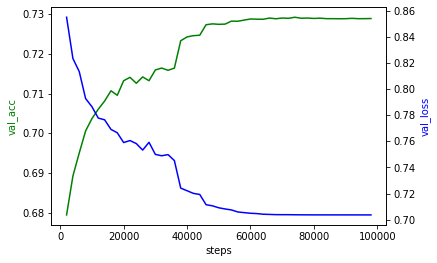

In [14]:
from matplotlib import pyplot as plt
x = custom_saver.history['batch']
y1 = custom_saver.history['val_acc']
y2 = custom_saver.history['val_loss']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('steps')
ax1.set_ylabel('val_acc', color='g')
ax2.set_ylabel('val_loss', color='b')